## Forecast Energy Consumption

## Data Description

### The dataset is obtained from Kaggle Dataset, and the original data is obtained from PJM Interconnection LLC.

### PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

### The hourly power consumption data comes from PJM's website and are in megawatts (MW).

### There are more than one power company's data in the original dataset. We will only explore the AEP (American Electrical Power) dataset in this project.

### The dataset contains two columns: the first one is the hourly timestamp from 2004-12-21 01am to 2018-01-02 12am; the second column shows the hourly energy consumption in MegaWatt unit. 

### The purpose of this project is to utilize the previous energy consumption to forecast the future energy consumption. This is an univariate time series analysis problem.

### In this project, we will utilize two approach to perform time series analysis. The first one is the traditional statistical approach, while the second is the supervised machine learning approach. There will be five different models used to perform the prediction. The prediction result will be measured with Mean Absoute Percentage Error (MAPE).

## Objective
## We will try to see if we can use machine learning algorithm to predict monthly energy consumption for AEP.

## Models

### 1. Holt Winter Exponential Smoothing (HWES)
### 2. Seasonal Autoregressive Integrated Moving Average (SARIMA)
### 3. Facbook - Prophet
### 4. Recurrent Neural Network - Long Short Term Memory (LSTM)
### 5. Supervised Learning - XGBoost

## Evaluation Metric
### Mean Absolute Percentage Error (MAPE)

In [166]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

from statsmodels.tsa.arima_model import ARMA
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from pandas import concat

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import StandardScaler

from fbprophet import Prophet

import timeit

## Data Exploration

In [3]:
df=pd.read_csv('AEP_hourly.csv')

In [4]:
df.head(5)

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [5]:
df.tail(5)

,Datetime,AEP_MW
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0
121272,2018-01-02 00:00:00,19993.0


In [6]:
df.columns=['Time','MW']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
Time    121273 non-null object
MW      121273 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [8]:
ts=pd.DataFrame(df['MW'])

## Indexing with Time Series Data

In [9]:
ts=ts.set_index(pd.to_datetime(df['Time']))
ts.head()

,MW
Time,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


## Visualize Hourly Energy Consumption

<Figure size 1080x720 with 0 Axes>

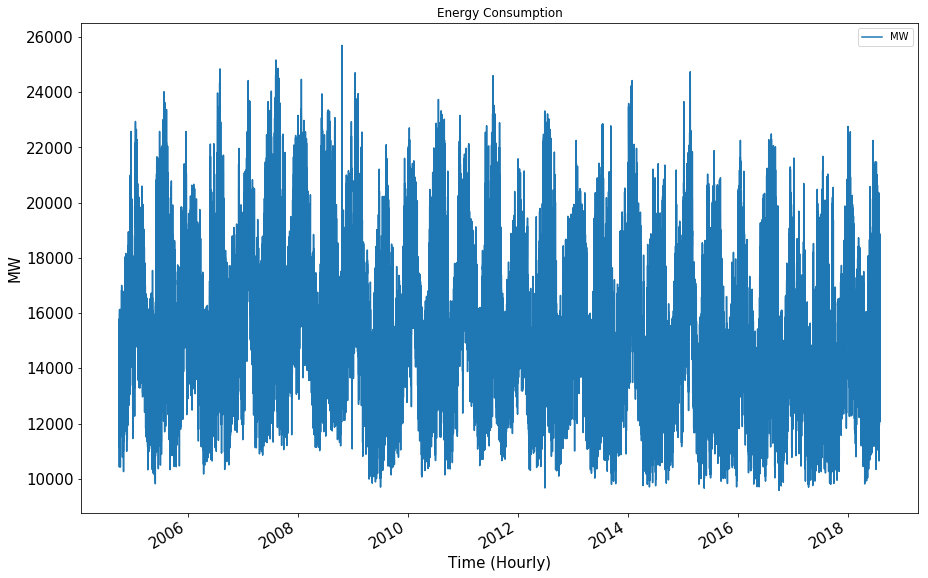

In [10]:
rcParams['figure.figsize'] = 15, 10
fig = plt.figure()
#plt.plot(ts)
ts.plot(fontsize=15)
plt.title('Energy Consumption')
plt.xlabel('Time (Hourly)', fontsize=15)
plt.ylabel('MW', fontsize=15)
plt.show()

### It is hard to tell what is going on with the original hourly energy consumption date. We can convert the original hourly data to monthly one and visualize the monthly energy consumption data instead.

## Visualize Monthly Energy Consumption

In [11]:
y = ts['MW'].resample('MS').mean()

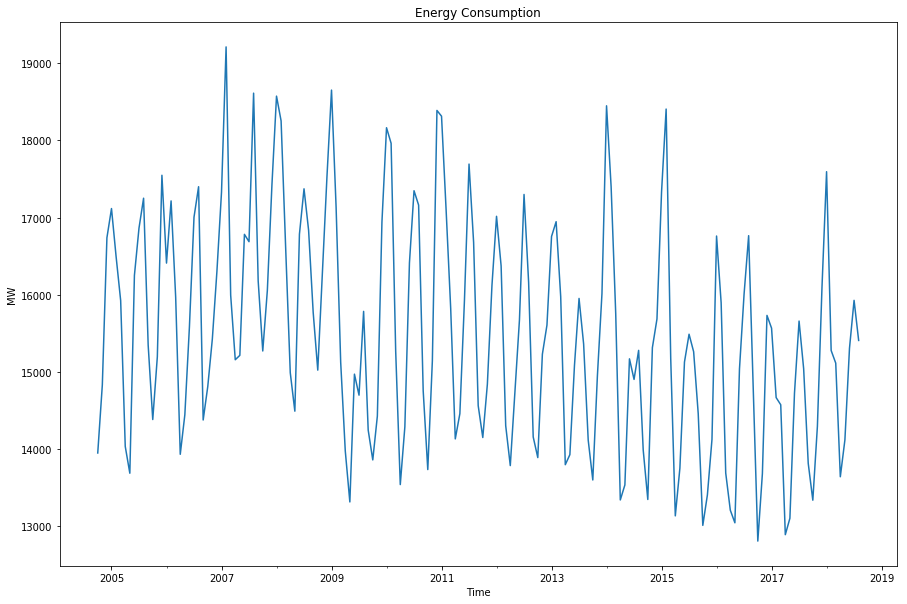

In [12]:
y.plot()
plt.title('Energy Consumption')
plt.ylabel('MW')
plt.show()

### Some distinguishable patterns appear when we plot the data. The time series has an obvious seasonality pattern, as well as an increasing, decreasing, and increasing trend.

## Stationarity Checking

## 1. Augmented Dickey-Fuller Test
### Null Hypotehsis (H0): If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
### Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary.
### p-value > 0.05: Accept H0, the data has a unit root and is non-stationary
### p-value ≤ 0.05: Reject H0. the data does not have a unit root and is stationary

In [13]:
result_test = adfuller(y)
print('ADF Statistic: %f' % result_test[0])
print('p-value: %f' % result_test[1])

ADF Statistic: -1.696009
p-value: 0.433170


## 2. Decomposition
### We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

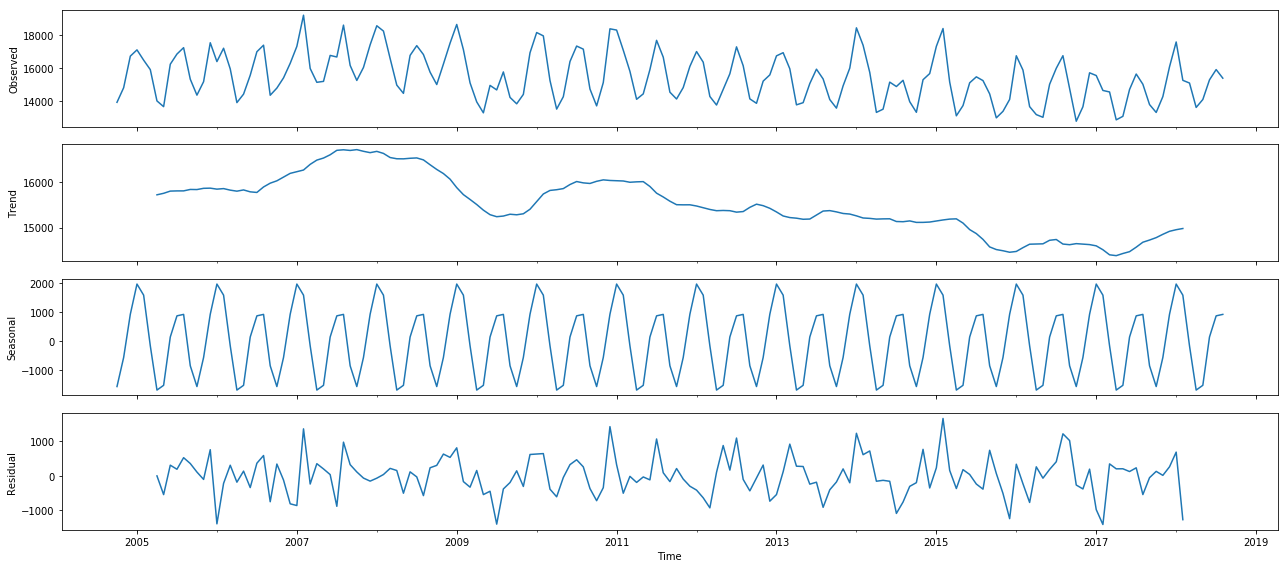

In [14]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

### The plot above clearly shows that the energy consumption is unstable, along with its obvious seasonality.

## Train/Test Split¶
### Cut off the data after 2017-01-01 to use as our validation set.

In [15]:
split_date = '2017-01-01'
y_train = y.loc[y.index < split_date].copy()
y_test = y.loc[y.index >= split_date].copy()

In [16]:
per_train=int(round(len(y_train)/len(y),2)*100)
per_test=100-per_train
print('Training Set is {}% of the whole dataset'.format(per_train))
print('Test Set is {}% of the whole dataset'.format(per_test))

Training Set is 88% of the whole dataset
Test Set is 12% of the whole dataset


## Define Evaluation Metrics

In [17]:
def MAPE(forecast,truth,model,df):
    diff=forecast-truth
    MAPE=str(round(abs(diff/truth).mean()*100,2))+'%'
    df['MAPE'][model]=MAPE
    print('The Mean Absolute Percentage Error (MAPE) of our forecasts is {}'.format(MAPE))

## Define a result table

In [18]:
result_df_index=['SARIMA',
                 'HWES',
                 'Prophet',
                 'LSTM',
                 'XGBoost']
result_df_col=['Time','MAPE']

result_df=pd.DataFrame(index=result_df_index, columns=result_df_col)

## 1. Holt Winter’s Exponential Smoothing (HWES)

In [19]:
from statsmodels.tsa.api import ExponentialSmoothing

In [108]:
model_HW = ExponentialSmoothing(y_train, seasonal_periods=12, trend='add', seasonal='mul')

## 1.1 Fitting HWES Model

In [109]:
start=timeit.default_timer()
model_HW_fit=model_HW.fit()
stop=timeit.default_timer()
result_df['Time']['HWES']=round(stop-start,2)
print("The running time is ",result_df['Time']['HWES'], "sec")

The running time is  1.5 sec


In [110]:
pred_HW = model_HW_fit.predict(start=pd.to_datetime(split_date),
                              end=y.index.max())

## 1.2 Model Diagnostic

In [117]:
pred_train_HW = model_HW_fit.predict(start=pd.to_datetime(y_train.index.min()),
                              end=y_train.index.max())

In [147]:
# Define residual
res_hw=pred_train_HW-y_train

# Standardize Residual
scaler=StandardScaler()
res_hw=scaler.fit_transform(res_hw.values.reshape(-1,1))

res_HW = pd.Series( (v[0] for v in res_hw), index=y_train.index)
res_HW=res_HW.reindex(index=y_train.index)

In [153]:
# define zero-residual
res_zero=[0]*len(y_train)
res_zero=pd.Series(res_zero,index=y_train.index)

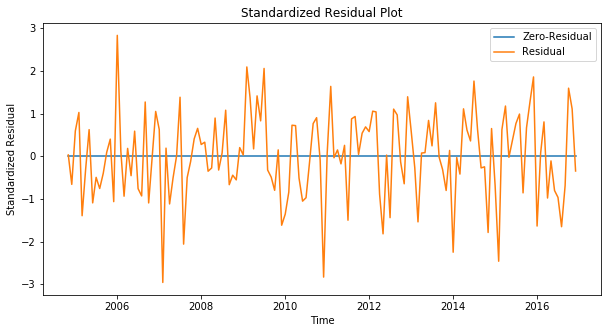

In [167]:
plt.figure(figsize=(10, 5))
plt.plot(res_zero, label="Zero-Residual")
plt.plot(res_HW, label="Residual")
plt.xlabel('Time')
plt.ylabel('Standardized Residual')
plt.title('Standardized Residual Plot')
plt.legend()
plt.show()

## 1.3 Prediction Evaluation

In [111]:
MAPE(pred_HW,y_test,'HWES',result_df)

The Mean Absolute Percentage Error (MAPE) of our forecasts is 3.13%


## 1.4 Prediction Visualization

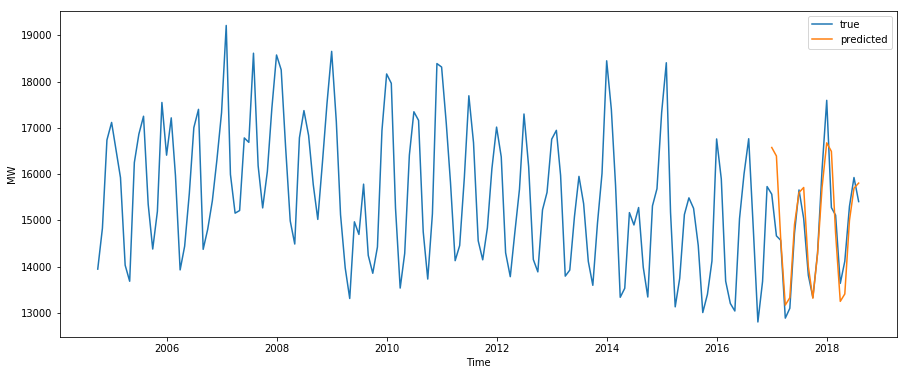

In [24]:
plt.figure(figsize=(15, 6))
plt.plot(y, label="true")
plt.plot(pred_HW, label="predicted")
plt.xlabel('Time')
plt.ylabel('MW')
plt.legend()
plt.show()

# 2. SARIMA

## 2.1 Determine the order of MA and AR models

## Taking the difference
### Since the orginal data is non-stationay, we will first perform differencing to make the data stationary.

In [25]:
y_train_diff=y_train.diff(1)

In [26]:
y_train_diff=y_train_diff[1:len(y_train_diff)]

## Double check if the data is stationary
### Augmented Dickey-Fuller Test

In [27]:
result_test_diff = adfuller(y_train_diff)
print('ADF Statistic: %f' % result_test_diff[0])
print('p-value: %f' % result_test_diff[1])

ADF Statistic: -3.614521
p-value: 0.005489


### Since the p-value is less than 0.05, we can conclude that the first differenced data is stationary.

## 2.1.1 Estimate the order of MA & AR model with ACF & PACF plots.

## Visualize the differenced data

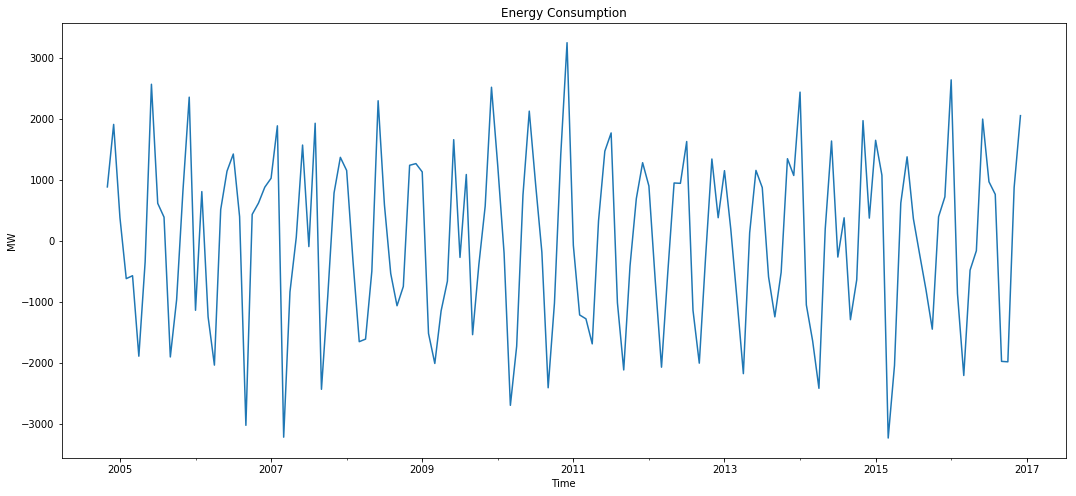

In [28]:
y_train_diff.plot()
plt.title('Energy Consumption')
plt.ylabel('MW')
plt.show()

## ACF Plot

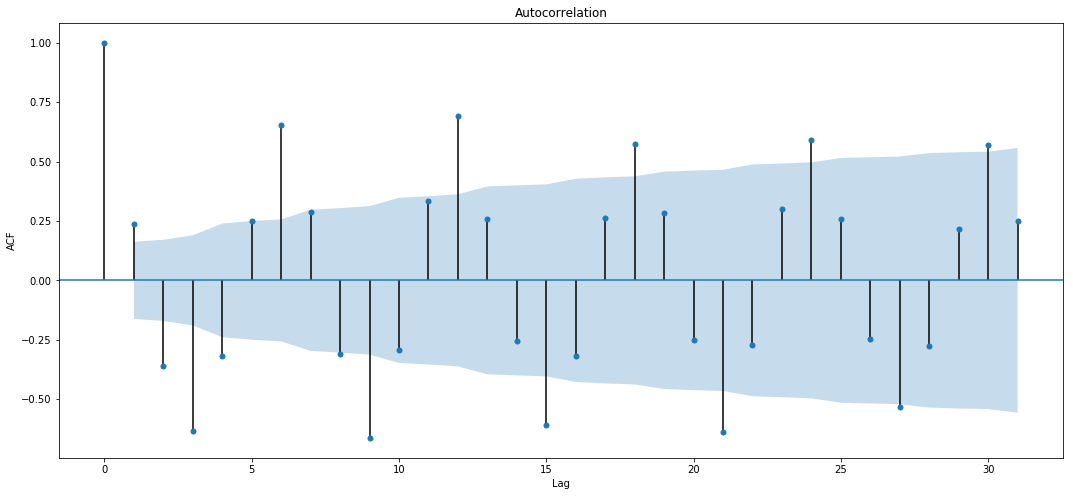

In [29]:
plot_acf(y_train_diff, lags=31, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

## We can estimate the order of the MA model from ACF plot above. The estimated order is 1 since that's where the ACF drops suddently after lag-1.

## PACF Plot

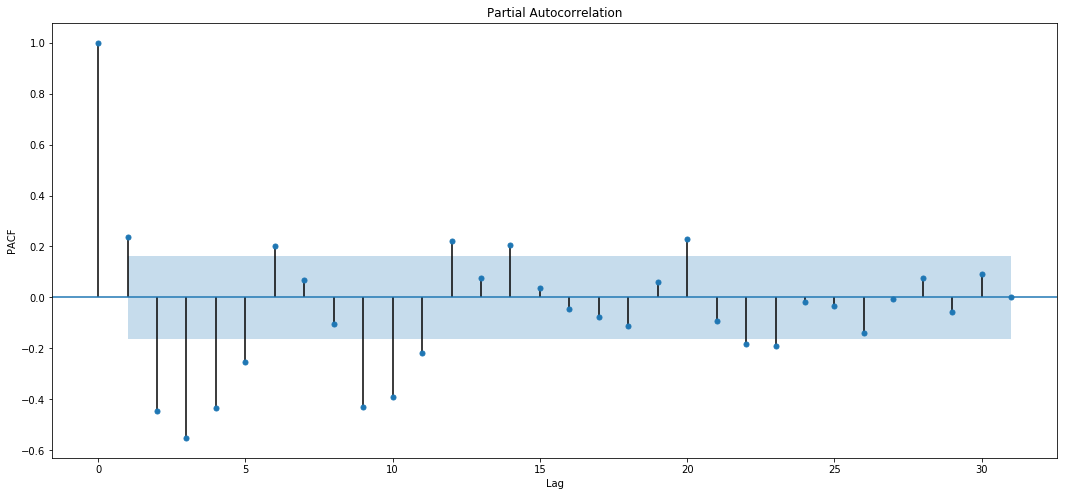

In [30]:
plot_pacf(y_train_diff, lags=31, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

## We can estimate the order of the AR model from PACF plot above. The estimated order is 1 since that's where the PACF drops suddently after lag-1.

## The estimated (p,d,q) for ARIMA model is (1,1,1)

## 2.1.2 Grid Search
### We will select the optimum ARIMA model with the lowest AIC (Akaike Information Criterion) value. A grid search technique will be used to find the optimal parameters in (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters, and in (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.

In [31]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [32]:
opt_pdq=(0,0,0)
opt_PDQ=(0,0,0,0)
opt_AIC=10000

In [33]:

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=False)
            results = mod.fit()
            #print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic<opt_AIC:
                opt_pdq=param
                opt_PDQ=param_seasonal
                opt_AIC=results.aic
        except:
            continue

print('Optimal SARIMA Model {}x{} - AIC:{}'.format(opt_pdq, opt_PDQ, opt_AIC))

/home/ren/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1052: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not params_seasonal_variance == []:
/home/ren/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


Optimal SARIMA Model (0, 1, 1)x(1, 1, 1, 12) - AIC:2171.567735580653


## 2.2 Fitting an ARIMA Time Series Model
### Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

### We'll start by plugging the optimal parameter values into a new SARIMAX model:

In [34]:
start=timeit.default_timer()
model_SARIMA = sm.tsa.statespace.SARIMAX(y_train,
                                order=opt_pdq,
                                seasonal_order=opt_PDQ,
                                enforce_stationarity=True,
                                enforce_invertibility=False)
model_SARIMA_fit = model_SARIMA.fit()
stop=timeit.default_timer()
result_df['Time']['SARIMA']=round(stop-start,2)
print(model_SARIMA_fit.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4688      0.051     -9.180      0.000      -0.569      -0.369
ar.S.L12       0.2514      0.128      1.970      0.049       0.001       0.502
ma.S.L12      -0.8361      0.133     -6.287      0.000      -1.097      -0.575
sigma2      4.926e+05   7.33e+04      6.719      0.000    3.49e+05    6.36e+05


###  The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

## 2.3 Model Diagnostics

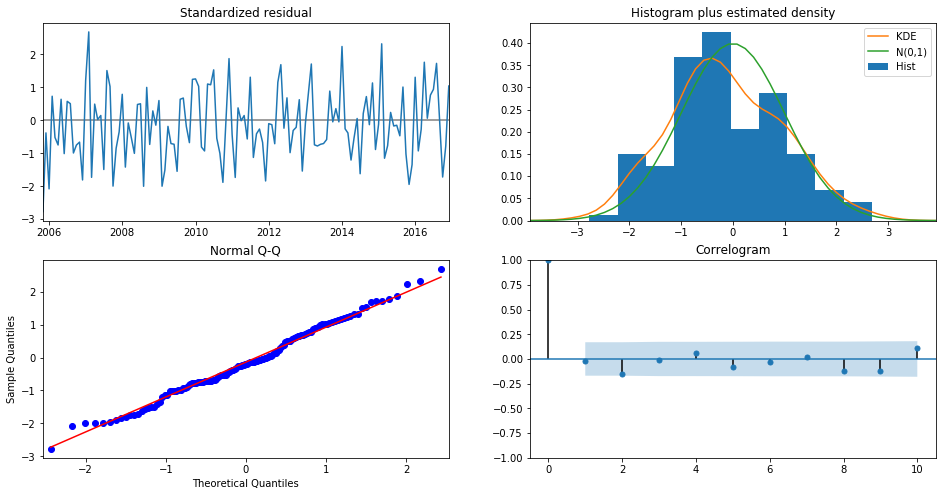

In [35]:
model_SARIMA_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

### Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

### In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

### In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.
### The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
### The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.
### Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

### Although we have a satisfactory fit, some parameters of our seasonal ARIMA model could be changed to improve our model fit. For example, our grid search only considered a restricted set of parameter combinations, so we may find better models if we widened the grid search.

In [36]:
pred_sarima = model_SARIMA_fit.get_prediction(start=pd.to_datetime(split_date),
                              end=y.index.max(),
                              dynamic=False)
pred_ci = pred_sarima.conf_int()
pred_SARIMA = pred_sarima.predicted_mean

## 2.4 Prediction Evaluation

In [37]:
MAPE(pred_SARIMA,y_test,'SARIMA',result_df)

The Mean Absolute Percentage Error (MAPE) of our forecasts is 3.85%


## 2.5 Prediction Visualization
### We have obtained a model for our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts.
### The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

### We can plot the real and forecasted values of the energy consumption time series to assess how well we did. The prediction date is set to start from 2017-01-01, which is the start date in the test set, to the end date of the dateset.

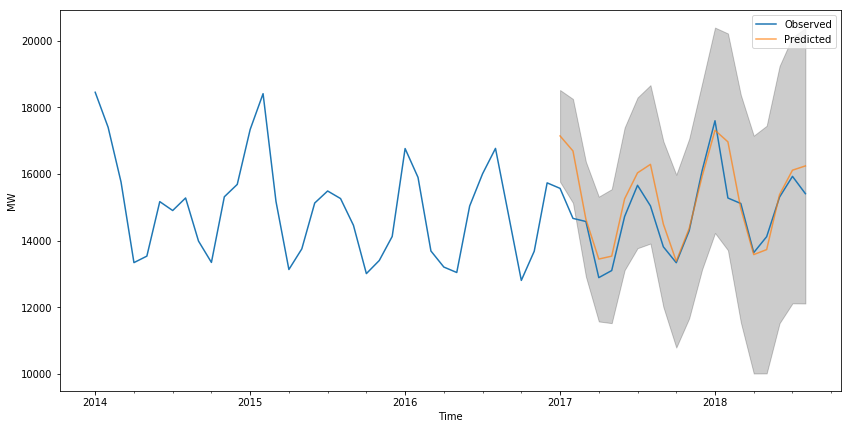

In [38]:
ax = y['2014':].plot(label='Observed')
pred_SARIMA.plot(ax=ax, label='Predicted', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Time')
ax.set_ylabel('MW')
plt.legend()
plt.show()

### The gray area shown is the 95% confidence interval. Overall, our forecasts align with the true values very well, showing an overall increase trend. 

## 2.6 Forecasting out-of-sample time

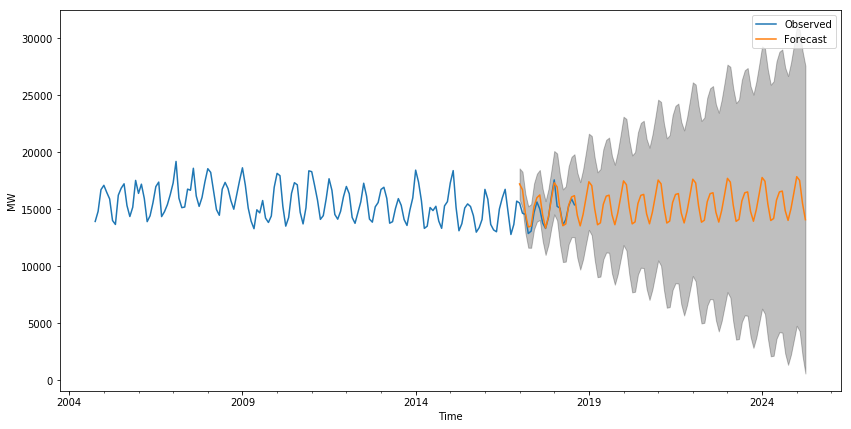

In [39]:
pred_future = results.get_forecast(steps=100)
pred_ci = pred_future.conf_int()
ax = y.plot(label='Observed', figsize=(14, 7))
pred_future.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Time')
ax.set_ylabel('MW')
plt.legend()
plt.show()

### Both the forecasts and associated confidence interval that we have generated can now be used to further understand the time series and foresee what to expect. Our forecasts show that the time series is expected to continue increasing at a steady pace.

### As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future. The confidence interval shown in the above plot is a hypothesis, and is not validated.

# 3. Facebook Prophet
### Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

## 3.1 Fitting the Prophet Model

In [40]:
y_train.head()

Time
2004-10-01    13947.537736
2004-11-01    14830.440278
2004-12-01    16737.720430
2005-01-01    17117.088710
2005-02-01    16496.644345
Freq: MS, Name: MW, dtype: float64

In [41]:
y_train_fb=y_train.reset_index()
y_train_fb.head()

,Time,MW
0,2004-10-01,13947.537736
1,2004-11-01,14830.440278
2,2004-12-01,16737.720430
3,2005-01-01,17117.088710
4,2005-02-01,16496.644345


In [42]:
# Rename the dataframe columns to ds(datestamp) and y as reuquired by Prophet
df_fb=y_train_fb.rename(columns={'Time':'ds', 'MW':'y'})
df_fb.head()

,ds,y
0,2004-10-01,13947.537736
1,2004-11-01,14830.440278
2,2004-12-01,16737.720430
3,2005-01-01,17117.088710
4,2005-02-01,16496.644345


In [43]:
start=timeit.default_timer()
model_fb = Prophet(interval_width=0.95,seasonality_mode='multiplicative')
#model_fb.add_seasonality(name='monthly', period=12, fourier_order=)
model_fb.fit(df_fb)

stop=timeit.default_timer()
result_df['Time']['Prophet']=round(stop-start,2)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## 3.2 Forecasting with Prophet Model

In [44]:
y_test_fb=y_test.reset_index()
y_test_fb.head()

,Time,MW
0,2017-01-01,15566.197581
1,2017-02-01,14665.684524
2,2017-03-01,14572.872140
3,2017-04-01,12888.327778
4,2017-05-01,13100.915323


In [45]:
forecast_time=pd.DataFrame(y_test_fb['Time'])
forecast_time.columns=['ds']

In [46]:
y_forecast_fb = model_fb.predict(forecast_time)
y_forecast_fb.head(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2017-01-01,14646.030765,15115.772654,17634.287735,14645.7183,14646.768311,0.120111,0.120111,0.120111,0.120111,0.120111,0.120111,0.0,0.0,0.0,16405.186181


## 3.3 Prediction Evaluation

In [47]:
MAPE(y_forecast_fb['yhat'],y_test_fb['MW'],'Prophet',result_df)

The Mean Absolute Percentage Error (MAPE) of our forecasts is 3.83%


In [48]:
y_forecast_fb.head(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2017-01-01,14646.030765,15115.772654,17634.287735,14645.7183,14646.768311,0.120111,0.120111,0.120111,0.120111,0.120111,0.120111,0.0,0.0,0.0,16405.186181


In [49]:
df1=pd.DataFrame(y_forecast_fb['yhat'])
df2=df1.set_index(y_forecast_fb['ds'])

In [50]:
df3=pd.DataFrame(y_forecast_fb[['yhat_lower','yhat_upper']])
df4=df3.set_index(y_forecast_fb['ds'])

## 3.4 Prediction Visualization

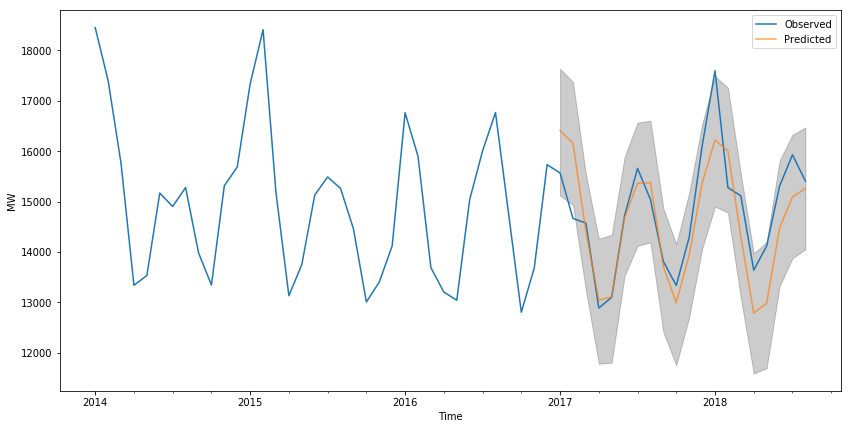

In [51]:
ax = y['2014':].plot(label='Observed')
pred_FB=df2.iloc[:,0]
pred_FB.plot(ax=ax, label='Predicted', alpha=.7, figsize=(14, 7))
ax.fill_between(df4.index,
                df4.iloc[:, 0],
                df4.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Time')
ax.set_ylabel('MW')
plt.legend()
plt.show()

## The gray area in the above plot is the 95% confidence interval.

# 4. Recurrent Neural Network - LSTM

In [52]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

In [53]:
y_train_array=y_train.values

In [54]:
# define training data
y_train_array.shape

(147,)

In [55]:
# reshape training data
n_features = 1
y_train_array = y_train_array.reshape((len(y_train_array), n_features))
y_train_array.shape

(147, 1)

## 4.1 TimeseriesGenerator 

### Keras provides the TimeseriesGenerator that can be used to automatically transform a univariate or multivariate time series dataset into a supervised learning problem.

In [56]:
# define generator
n_input = 6
generator = TimeseriesGenerator(y_train_array, y_train_array, length=n_input, batch_size=len(y_train_array)-n_input)
generator

In [57]:
# define model
model_lstm = Sequential()
model_lstm.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

In [58]:
len(generator)

1

## 4.2 Fitting LSTM Model

In [59]:
start=timeit.default_timer()
model_lstm.fit_generator(generator, steps_per_epoch=1, epochs=500, verbose=0)
stop=timeit.default_timer()
result_df['Time']['LSTM']=round(stop-start,2)

In [60]:
pred_lstm=[]
# make a one step prediction out of sample
for i in range(0,len(y_test)):
    x_past=y.values[len(y_train)-n_input+i:len(y_train)+i]
    x_input = x_past.reshape((1, n_input, n_features))
    yhat = model_lstm.predict(x_input, verbose=0)
    pred_lstm.append(yhat[0,0])

## 4.3 Prediction Evaluation

In [61]:
MAPE(pred_lstm,y_test.values,'LSTM',result_df)

The Mean Absolute Percentage Error (MAPE) of our forecasts is 5.16%


## 4.4 Prediction Visualization

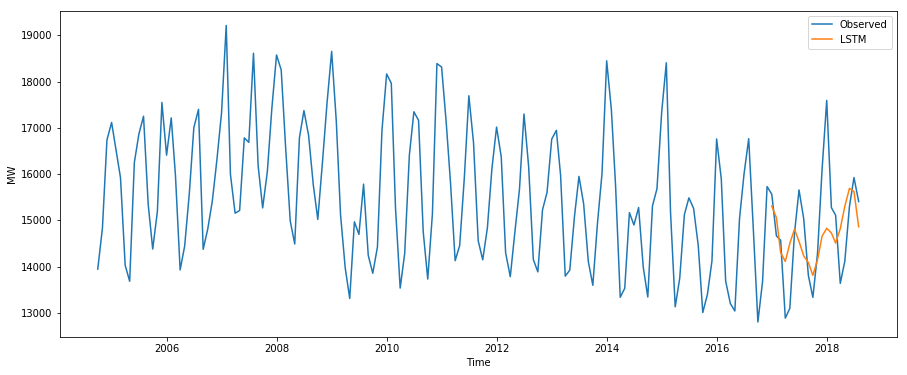

In [62]:
#convert list to series, and reindex
pred_LSTM=pd.Series(pred_lstm,index=y_test.index)

plt.figure(figsize=(15, 6))
plt.plot(y, label="Observed")
plt.plot(pred_LSTM, label="LSTM")
plt.xlabel('Time')
plt.ylabel('MW')
plt.legend()
plt.show()

# 5. Supervised Learning - XBoost

## 5.1 Feature Engineering with TSFRESH

### TSFRESH stands for “ Time Series Feature extraction based on scalable hypothesis tests”. tsfresh is a python package. It automatically calculates a large number of time series characteristics, the so called features. Further the package contains methods to evaluate the explaining power and importance of such characteristics for regression or classification tasks.

https://github.com/blue-yonder/tsfresh/tree/master/notebooks

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute

import warnings
warnings.filterwarnings('ignore')

In [64]:
%load_ext autoreload
%autoreload 2

In [65]:
from tsfresh.utilities.dataframe_functions import roll_time_series

In [66]:
df_shift, ts_y = make_forecasting_frame(y, kind="price", max_timeshift=10, rolling_direction=1)

In [67]:
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute, 
                     show_warnings=False)

Feature Extraction: 100%|██████████| 28/28 [00:02<00:00, 12.51it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_tre

In [68]:
col_drop=[]
for i in range(len(X.columns)):
    if ((X.iloc[:,i]==0).sum())==len(X):
       col_drop.append(X.columns[i])

In [69]:
for i in col_drop:
    X=X.drop(i,axis=1)

In [70]:
split_date = '2017-01-01'
x_train = X.loc[X.index < split_date].copy()
x_test = X.loc[X.index >= split_date].copy()

y_train = ts_y.loc[X.index < split_date].copy()
y_test = ts_y.loc[X.index >= split_date].copy()

In [71]:
y_train.head(1)

Time
2004-11-01    14830.440278
Freq: MS, Name: value, dtype: float64

In [72]:
X.head(1)

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""","value__agg_autocorrelation__f_agg_""median""","value__agg_autocorrelation__f_agg_""var""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""slope""","value__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""intercept""","value__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""rvalue""",...,value__symmetry_looking__r_0.75,value__symmetry_looking__r_0.8,value__symmetry_looking__r_0.8500000000000001,value__symmetry_looking__r_0.9,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__variance,value__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
2004-11-01,1.945338e+08,0.0,0.0,0.0,0.0,17251.090054,-1.0,-71.563853,15604.024561,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
x_test.head(1)

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""","value__agg_autocorrelation__f_agg_""median""","value__agg_autocorrelation__f_agg_""var""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""slope""","value__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""intercept""","value__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""rvalue""",...,value__symmetry_looking__r_0.75,value__symmetry_looking__r_0.8,value__symmetry_looking__r_0.8500000000000001,value__symmetry_looking__r_0.9,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__variance,value__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2.112481e+09,11254.617677,-0.130883,-0.280491,0.192735,16004.576613,1.0,760.724462,14195.401403,1.0,...,1.0,1.0,1.0,1.0,1.0,1.249002e+11,1.311884e+11,2.266749e+11,1.728130e+06,1.0


In [74]:
y_test.head(1)

Time
2017-01-01    15566.197581
Freq: MS, Name: value, dtype: float64

## 5.2 XGBoost Modeling

In [75]:
from sklearn import ensemble
from xgboost import XGBRegressor as xgb
start=timeit.default_timer()
model_XG = xgb()
model_XG.fit(x_train,y_train)
stop=timeit.default_timer()
result_df['Time']['XGBoost']=round(stop-start,2)

In [76]:
pred_xg = model_XG.predict(data=x_test)

## 5.3 Prediction Evaluation

In [77]:
MAPE(pred_xg,y_test.values,'XGBoost',result_df)

The Mean Absolute Percentage Error (MAPE) of our forecasts is 5.44%


## 5.4 Prediction Visualization

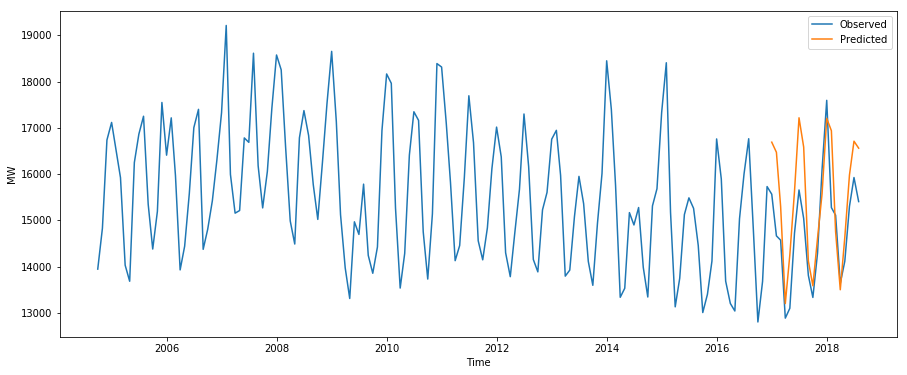

In [78]:
# convert list to series, and reindex.
pred_XG=pd.Series(pred_xg,index=y_test.index)

plt.figure(figsize=(15, 6))
plt.plot(y, label="Observed")
plt.plot(pred_XG, label="Predicted")
plt.xlabel('Time')
plt.ylabel('MW')
plt.legend()
plt.show()

## Forecasting Comparison

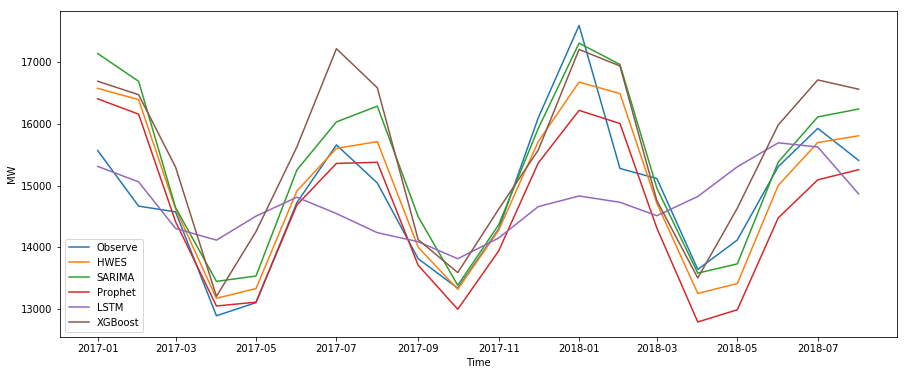

In [79]:
plt.figure(figsize=(15, 6))
plt.plot(y_test, label="Observe")
plt.plot(pred_HW, label="HWES")
plt.plot(pred_SARIMA, label="SARIMA")
plt.plot(pred_FB, label="Prophet")
plt.plot(pred_LSTM, label="LSTM")
plt.plot(pred_XG, label="XGBoost")
plt.xlabel('Time')
plt.ylabel('MW')
plt.legend()
plt.show()

## Result Summary

In [80]:
result_df

,Time,MAPE
SARIMA,0.36,3.85%
HWES,1.68,3.12%
Prophet,0.04,3.83%
LSTM,51.9,5.16%
XGBoost,0.14,5.44%


## Model Accuracy Ranking

In [81]:
result_df.sort_values(by='MAPE', ascending=True)

,Time,MAPE
HWES,1.68,3.12%
Prophet,0.04,3.83%
SARIMA,0.36,3.85%
LSTM,51.9,5.16%
XGBoost,0.14,5.44%


## Modeling Time Ranking

In [82]:
result_df.sort_values(by='Time', ascending=True)

,Time,MAPE
Prophet,0.04,3.83%
XGBoost,0.14,5.44%
SARIMA,0.36,3.85%
HWES,1.68,3.12%
LSTM,51.9,5.16%


## Conclusion

## 1. The results show that we can predict the monthly energy consumptions very well, especially with the statistical approach.

## 2. This project uses different approach to predict the energy consumption. With modeling time and accuracy in consideration, the SARIMA model performs the best overall. Hence, for the similar time series dataset, SARIMA model can be used as a benchmark model for forecasting the future target values.

## Recommendation
## 1. There is an upward trend in energy consumption since year 2017. AEP may need to further investigate to see which area of service have caused this overall increase. More detailed data will be needed for this investigation.
## 2. AEP may need to start planning for either existing power plant expansion or new power plant construction since the overall energy consumption is going up.
## 3. This study only investigates the monthly energy consumption. AEP may investigate the energy consumption with different timestamp, e.g. daily, hourly, yearly to see how energy consumption changes with these different time steps.
## 4. AEP can use this modeling result to decide whether to expand its existing power plants or downside them. This will reduce the company's overall operating cost and will be able to offer cheaper price for their customers. The company will be more competitive in the energy market.